<a href="https://colab.research.google.com/github/GrinkoL/idchess_zadanie/blob/main/idchess_zadanie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from shapely.geometry import box, Polygon
try:
    from livelossplot import PlotLossesKeras
except ModuleNotFoundError:
    !pip install livelossplot
    from livelossplot import PlotLossesKeras
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Layer

In [2]:
# Функция для распаковки архивов.
def unzip(zip_file_path, dir_path):
    '''
    Распаковывает zip архив

    Параметры
    ---------------
    file_zip: str
        Полный путь до tar архива
    dir: str
        Директория, в которую распаковывается архив
    
    Возвращаемое/мые значения
    ----------------
    Отсутствует
    '''

    if not os.path.exists(dir_path):   
        !mkdir $dir_path
    !cd $dir_path && unzip $zip_file_path

# Класс для перехода от черно-белого изображения с одним каналом к трёхканальному чёрно-белому изображению.
# Далее он будет использоваться как состовная часть нейросетевой модели.
class GrayscaleToRGBLayer(Layer): 
    def __init__(self, output_dim, **kwargs): 
        self.output_dim = output_dim 
        super(GrayscaleToRGBLayer, self).__init__(**kwargs) 
    def call(self, input_data):
        return tf.keras.backend.repeat_elements(input_data, self.output_dim, axis=3)

def create_model(input_shape=(256,256,3)):
    '''
    Cоздание нейросетевой модели. Используется подход transfer learning.
    В качестве базовой модели используется mobilenet предобученная на imagenet
    датасете

    Параметры
    --------------------
    input_shape:tuple
        Размер входного тензора 

    Возвращаемое/мые значения
    --------------------
    model:tensorflow.python.keras.engine.sequential.Sequential
        Ссылка на модель типа Sequentional
    '''
 
    base_model = MobileNetV2(input_shape=input_shape, include_top=False)

    # Откроем для обучения несколько топовых слоёв в базовой модели:
    for layer in base_model.layers[:-38]:
        layer.trainable = False

    # Cоберём модель:
    model =  Sequential([GrayscaleToRGBLayer(3,input_shape=(256,256,1)),base_model, GlobalAveragePooling2D(),
                         Dense(128, activation='relu'),
                         Dense(128, activation='relu'),
                         Dense(8, activation=None)])
    return model

def loss_box(y_true, y_pred):
    '''
    Вычисляет детекционный лос
    '''
    return tf.losses.MSE(y_true, y_pred)

def meanIoU(y_true, y_pred):
    '''
    Делегирует вычисления meanIoU на функцию calculate_meanIoU для того,
    чтобы работать с numpy массивами, а не с EagerTensor
    '''
    mIoU = tf.py_function(calculate_meanIoU, [y_true, y_pred], tf.float32)
    return mIoU

def calculate_meanIoU(y_true_matrix, y_pred_matrix):
    '''
    Вычисляет метрику mIoU в процентах

    Параметры
    --------------------
    y_true: numpy.ndarray
        Двумерный массив, нулевое измерение которого равно количеству элементов
        в батче, а первое - 8ти
    y_pred: numpy.ndarray
        Аналогично y_true

    Возвращаемое/мые значения
    --------------------
    :float
        Значение метрики mIoU в процентах
    '''
    iou_list = []
    for y_true, y_pred in zip(y_true_matrix, y_pred_matrix):
        quad_true_xy = [[y_true[0], y_true[1]], [y_true[2], y_true[3]], [y_true[4], y_true[5]], [y_true[6], y_true[7]]]
        quad_pred_xy = [[y_pred[0], y_pred[1]], [y_pred[2], y_pred[3]], [y_pred[4], y_pred[5]], [y_pred[6], y_pred[7]]]
        quad_true_shape = Polygon(quad_true_xy)
        quad_pred_shape = Polygon(quad_pred_xy)
        if quad_pred_shape.is_valid: # Если нет самопересечений
            polygon_intersection = quad_true_shape.intersection(quad_pred_shape).area
            polygon_union = quad_true_shape.union(quad_pred_shape).area
            iou = polygon_intersection / polygon_union
        else: # при обнаружении самопересечений зануляем метрику IoU
            iou = 0
        iou_list.append(iou)
    meanIoU = np.mean(iou_list)
    return meanIoU * 100

In [3]:
drive.mount('/GDrive')

Mounted at /GDrive


In [4]:
DATASET_ZIP_PATH = '/GDrive/MyDrive/freefleks/idchess_zadanie.zip'
DATASET_DIR_PATH = 'idchess_zadanie'
BATCH_SIZE = 100

unzip(DATASET_ZIP_PATH, DATASET_DIR_PATH)

x_train_initial = np.load('idchess_zadanie/xtrain.npy')
y_train_initial = np.load('idchess_zadanie/ytrain.npy')

# Разделяем данные на данные для обучения и валидации, 80% на обучение, 20% на валидацию, а
# также подготавливаем генратор с функцией предобработки данных для подачи данных в модель при её обучении.
x_train, x_valid, y_train, y_valid = train_test_split(x_train_initial, y_train_initial, test_size=0.2, random_state = 11)
imageDataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input)
iterator_train = imageDataGenerator.flow(x=x_train, y=y_train, batch_size=BATCH_SIZE)

Archive:  /GDrive/MyDrive/freefleks/idchess_zadanie.zip
  inflating: ytrain.npy              
  inflating: xtest.npy               
  inflating: xtrain.npy              


In [6]:
model = create_model()
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss=loss_box, metrics=[meanIoU])

9420800/9406464 [==============================] - 0s 0us/step


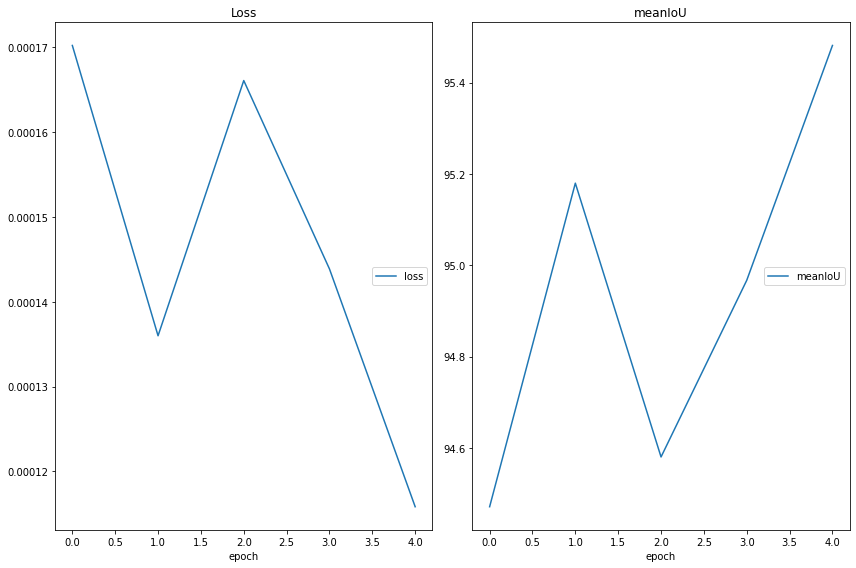

Loss
	loss             	 (min:    0.000, max:    0.000, cur:    0.000)
meanIoU
	meanIoU          	 (min:   94.471, max:   95.481, cur:   95.481)


In [ ]:
model.fit(iterator_train, epochs=20, callbacks=[PlotLossesKeras()])
# График отрисован для последних 4х эпох.

In [ ]:
# model.save('/GDrive/MyDrive/freefleks/model_valid_mIoU_66_65_over_20_epoch_lr_10_-2')
# model.load_weights('/GDrive/MyDrive/freefleks/model_valid_mIoU_66_65_over_20_epoch_lr_10_-2')

In [8]:
# Проверим работу модели на валидационном наборе данных.
y_valid_pred = model.predict(x_valid)
calculate_meanIoU(y_valid, y_valid_pred)

66.65651183506631

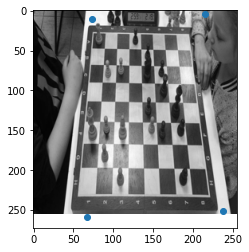

In [ ]:
# Визуализируем работу модели на каком-нибудь примере из валидационного набора.
# Возьмём, напрмер, доску под номером 40.
num = 40
y_valid_pred = model.predict(x_valid[num][None,...])*256
plt.imshow(x_valid[num][:,:,0], cmap='gray')
plt.scatter([y_valid_pred[0][i] for i in range(0,8,2)], [y_valid_pred[0][i] for i in range(1,8,2)])

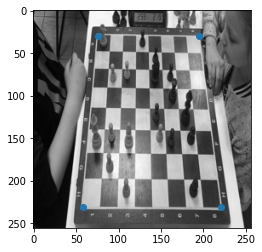

In [ ]:
# Сравним с истинной разметкой той же 40 доски.
y_valid_true = y_valid[num]*256
plt.imshow(x_valid[num][:,:,0], cmap='gray')
plt.scatter([y_valid_true[i] for i in range(0,8,2)], [y_valid_true[i] for i in range(1,8,2)])

#Итог:
На выбранной архитектуре, поэкспериментировав с гиперпораметрами удалось достич значения метрики meanIoU равной 66.65% на валидационном датасете. Предполагаю, что дальнейшее увеличение метрики возможно при разных сценариях. Например, добавить ряд свёрточных слоёв после базовой модели, использовать другую архитектуру, аугментировать (например путём поворотов или масштабирования с обрезание) тренеровочного набора данных.